In [1]:
import numpy as np
import pandas as pd

data=pd.read_csv("F:\Tutorials\Certified program in MACHINE LEARNING and ARTIFICIAL INTELLIGENCE\Assignments\project\dataset\data.csv",encoding='unicode_escape')
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [2]:
data=data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5836 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5836 non-null   object
 1   Sentiment  5836 non-null   object
dtypes: object(2)
memory usage: 136.8+ KB


In [3]:
#labeling target variable
dict_label= {'positive': 0, 'neutral': 0 , 'negative': 1}
data.Sentiment = data.Sentiment.map(dict_label)
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,0
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1
2,"For the last quarter of 2010 , Componenta 's n...",0
3,According to the Finnish-Russian Chamber of Co...,0
4,The Swedish buyout firm has sold its remaining...,0


In [4]:
data.Sentiment.value_counts()

0    4976
1     860
Name: Sentiment, dtype: int64

In [5]:
4976//860

5

## Split data to train and test 

In [6]:
from sklearn.model_selection import train_test_split
XTrain,XTest=train_test_split(data,test_size=0.2,random_state=42)

In [7]:
XTest=XTest.reset_index(drop=True)
XTest.head()

,Sentence,Sentiment
0,EBIT margin was up from 1.4 % to 5.1 % .,0
1,"According to Vauramo , the plant 's lifting eq...",0
2,"In food trade , sales amounted to EUR320 .1 m ...",1
3,Commission income fell to EUR 4.6 mn from EUR ...,0
4,Alma Media 's operating profit amounted to EUR...,1


In [8]:
XTrain.Sentiment.value_counts()

0    3967
1     701
Name: Sentiment, dtype: int64

In [9]:
3988//690

5

## Create the dataframe to be augmented 

In [10]:
dfXTrain=XTrain[XTrain["Sentiment"]==1].reset_index(drop=True)
dfXTrain.head()

,Sentence,Sentiment
0,3rd red day in a row ? $TSLA,1
1,"Tesco, Asda sales fall as march of the discoun...",1
2,"@Dlerch LOL! $FMCN back under $17, darn those ...",1
3,The period-end cash and cash equivalents total...,1
4,Tallink Silja attributes the significant drop ...,1


## Data Augmentation by Synonym Replacement 

In [11]:
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import random 

def get_synonyms(word):
    
    synonyms = set()
    
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

stop_words = []
for w in stopwords.words('english'):
    stop_words.append(w)
#print(stop_words)

def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

In [12]:

dfXTrain_Aug=[]
for k in range(len(dfXTrain)):
    trial_sent = dfXTrain.Sentence[k]
    for n in range(5):
        txt= synonym_replacement(trial_sent,n)
        dfXTrain_Aug.append(txt)

In [13]:
dfXTrainAugmented=pd.DataFrame(dfXTrain_Aug,columns=['Sentence'])
dfXTrainAugmented['Sentiment'] = 1
dfXTrainAugmented.head(10)

,Sentence,Sentiment
0,3rd red day in a row ? $TSLA,1
1,3rd red clarence day in a row ? $TSLA,1
2,third red twenty four hour period in a row ? $...,1
3,third carmine solar day in a row ? $TSLA,1
4,third cherry twenty four hours in a quarrel ? ...,1
5,"Tesco, Asda sales fall as march of the discoun...",1
6,"Tesco, Asda sales fall as edge of the discount...",1
7,"Tesco, Asda sales agreement fall down as march...",1
8,"Tesco, Asda sale twilight as march of the whol...",1
9,"Tesco, Asda sales agreement flow as master of ...",1


In [14]:
df1=XTrain[XTrain["Sentiment"]==0].reset_index(drop=True)
df2=dfXTrainAugmented
frames = [df1, df2]
  
XTrain = pd.concat(frames)
display(XTrain )

,Sentence,Sentiment
0,It is hand-painted resin with real 14-0 treble...,0
1,"The customer is then forwarded to the site , a...",0
2,$GTE LONG at 7.44,0
3,Operating loss amounted to EUR 0.9 mn in the f...,0
4,"LLC , a voice and data management solution pro...",0
...,...,...
3500,"Due to the rapid decrease in net sales , perso...",1
3501,"Due to the rapid diminution in net sales , per...",1
3502,"Due to the rapid decrease in net sales , perso...",1
3503,"Due to the speedy decrease in net sales , pers...",1


In [15]:
XTrain .Sentiment.value_counts()

0    3967
1    3505
Name: Sentiment, dtype: int64

# Data Preprocessing

In [16]:
from keras.preprocessing import text
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 1000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize our training data
tokenizer=text.Tokenizer(num_words=num_words,oov_token=oov_token)
tokenizer.fit_on_texts(list(XTrain.Sentence))
# Get our training data word index
word_index = tokenizer.word_index
# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(XTrain.Sentence)
# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)


print("\nPadded training shape:", train_padded.shape)



Padded training shape: (7472, 71)


In [17]:
test_sequences = tokenizer.texts_to_sequences(XTest.Sentence)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

print("\nPadded testing shape:",test_padded.shape)



Padded testing shape: (1168, 71)


In [18]:
for x, y in zip(XTest.Sentence, test_padded):
  print('{} -> {}'.format(x, y))

print("\nWord index (for reference):", word_index)

EBIT margin was up from 1.4 % to 5.1 % . -> [708 351  38  54  10  18  43   5  29  18   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
According to Vauramo , the plant 's lifting equipment is suitable for Asian and for some Chinese trucks . -> [143   5   1   2 180  12   1 281  14   1   9   1   6   9 104   1   1   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
In food trade , sales amounted to EUR320 .1 m , a decline of 1.1 % . -> [  4 523 264  23 308   5   1  18  40   7   1   3  18  18   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

## RNN Model

In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SimpleRNN,Dropout

model=Sequential()
model.add(Embedding(input_dim=len(word_index)+1,output_dim=128))
model.add(SimpleRNN(70))
model.add(Dropout(0.5))
model.add(Dense(20,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1526656   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 70)                13930     
_________________________________________________________________
dropout (Dropout)            (None, 70)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1420      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,542,027
Trainable params: 1,542,027
Non-trainable params: 0
______________________________________________

In [21]:
X_train,y_train=train_padded,XTrain.Sentiment
X_test,y_test=test_padded,XTest.Sentiment

In [22]:
history=model.fit(X_train,y_train,batch_size=128,epochs=20,verbose=2,validation_data=(X_test,y_test ))

Epoch 1/20
59/59 - 3s - loss: 0.6932 - accuracy: 0.5159 - val_loss: 0.6166 - val_accuracy: 0.7817
Epoch 2/20
59/59 - 3s - loss: 0.6574 - accuracy: 0.6200 - val_loss: 0.5773 - val_accuracy: 0.7466
Epoch 3/20
59/59 - 3s - loss: 0.5723 - accuracy: 0.7400 - val_loss: 0.5885 - val_accuracy: 0.7611
Epoch 4/20
59/59 - 3s - loss: 0.5096 - accuracy: 0.7815 - val_loss: 0.5200 - val_accuracy: 0.7414
Epoch 5/20
59/59 - 3s - loss: 0.4500 - accuracy: 0.8215 - val_loss: 0.4860 - val_accuracy: 0.7748
Epoch 6/20
59/59 - 3s - loss: 0.4052 - accuracy: 0.8365 - val_loss: 0.5790 - val_accuracy: 0.7029
Epoch 7/20
59/59 - 3s - loss: 0.3795 - accuracy: 0.8500 - val_loss: 0.5579 - val_accuracy: 0.7320
Epoch 8/20
59/59 - 3s - loss: 0.3660 - accuracy: 0.8577 - val_loss: 0.6098 - val_accuracy: 0.7491
Epoch 9/20
59/59 - 3s - loss: 0.3320 - accuracy: 0.8745 - val_loss: 0.6307 - val_accuracy: 0.7303
Epoch 10/20
59/59 - 3s - loss: 0.3341 - accuracy: 0.8723 - val_loss: 0.6289 - val_accuracy: 0.7140
Epoch 11/20
59/59 -

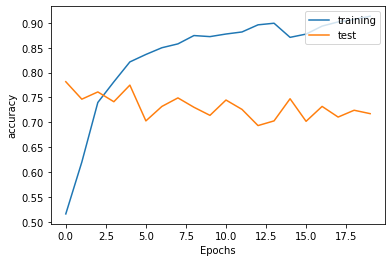

In [23]:
import matplotlib.pyplot as plt
metrics='accuracy'
plt.plot(history.history[metrics])
plt.plot(history.history['val_'+ metrics])
plt.xlabel('Epochs')
plt.ylabel(metrics)
plt.legend(['training', 'test'], loc='upper right')
plt.show()
     